# 6-1. 프로젝트: 인물 모드 문제점 찾기
<br>

만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


### Step 1. 인물모드 직접 해 보기

---  
여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다.  
아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.


인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 
시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.

배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다.  
여러분만의 환상적인 사진을 만들어 보면 어떨까요?

---

In [2]:
# 필요한 라이브러리 모듈 불러오기

import os
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 변수명이 혼란스러워 중간 RunTime 실행결과 결과가 혼잡하게 나오므로 다음과 같이 조치함.

# 인물 사진 변수명을 다음과 같이 변경한다. 

'''

img_path --> img_person
img_orig --> img_orig_person

img_path2 --> img_dog
img_orig2 --> img_orig_dog

print('슝=3')
'''

"\n\nimg_path --> img_person\nimg_orig --> img_orig_person\n\nimg_path2 --> img_dog\nimg_orig2 --> img_orig_dog\n\nprint('슝=3')\n"

(2048, 1536, 3)
(666, 1000, 3)


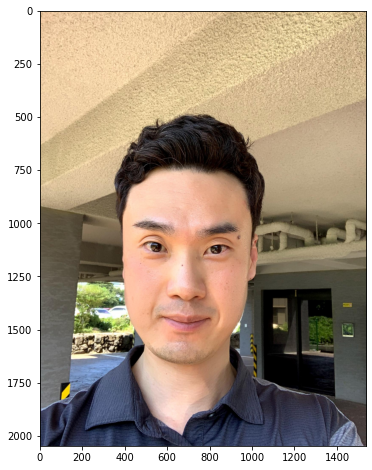

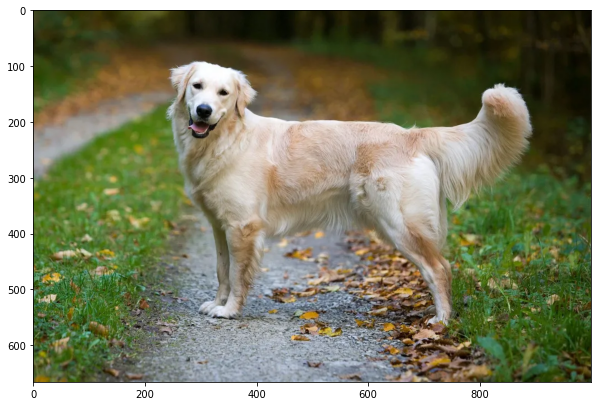

In [3]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

# 첫번째 이미지 사진
img_person = os.getenv('HOME')+'/aiffel/human_segmentation/images/chophilsun face.jpeg'  
img_orig_person = cv2.imread(img_person) 

# 두번째 이미지 사진
img_dog = os.getenv('HOME')+'/aiffel/human_segmentation/images/Golden Retriever.jpeg'  
img_orig_dog = cv2.imread(img_dog) 

# 원본 이미지의 크기 출력
print(img_orig_person.shape)       # 첫 번째 인물사진 원본 이미지 출력
print(img_orig_dog.shape)          # 두 번째 동물사진 원본 이미지 출력


# 첫번째 인물사진 더 큰 피규어 생성 
plt.figure(figsize=(10,8))  # 원하는 크기로 조절 가능하다.

plt.imshow(cv2.cvtColor(img_orig_person, cv2.COLOR_BGR2RGB))
plt.show()


# 두번째 동물사진 더 큰 피규어 생성
plt.figure(figsize=(10,8))  # 원하는 크기로 조절 가능하다.


plt.imshow(cv2.cvtColor(img_orig_dog, cv2.COLOR_BGR2RGB))
plt.show()


# 세그멘테이션으로 사람 분리하기

In [4]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. 
# model_dir 에 "/aiffel/human_segmentation/models" 저장

# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 
# "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장


# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 


# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 


# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 


# 다운로드를 시작합니다
# urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f1b47a7d940>)

In [5]:
#PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model = semantic_segmentation() 

# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file) 

In [6]:
#pascalvoc 데이터의 라벨종류

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

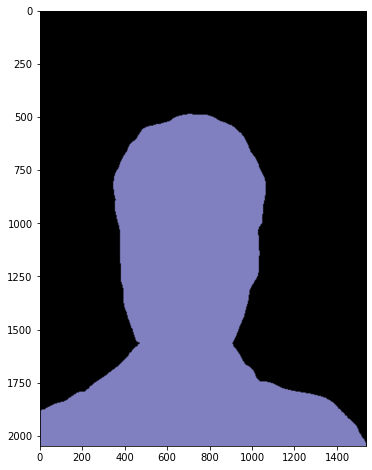

In [7]:
# segmentAsPascalvoc()함수를 호출 하여 입력된 이미지를 분할  <첫번째 인물사진>
# 분할 출력의 배열을 가져옴, 분할은 pacalvoc 데이터로 학습된 모델을 이용

segvalues, output = model.segmentAsPascalvoc(img_person)         # 첫번째 인물사진

#segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력

# 더 큰 피규어 생성
plt.figure(figsize=(10,8))                                      # 원하는 크기로 조절 가능하다.

plt.imshow(output)
plt.show()

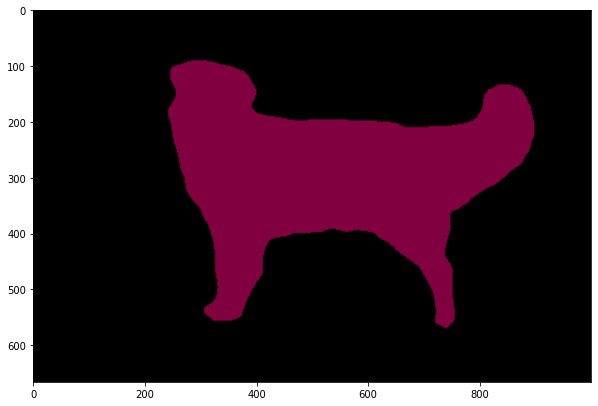

In [8]:
# segmentAsPascalvoc()함수를 호출 하여 입력된 이미지를 분할  <두번째 동물사진>
# 분할 출력의 배열을 가져옴, 분할은 pacalvoc 데이터로 학습된 모델을 이용

segvalues2, output2 = model.segmentAsPascalvoc(img_dog)        # 두번째 동물사진

# --> 오류 발생 : 동물사진이 segvalues2, output2에 제대로 할당이 안되는 것 같음. 위의 segvalues2에 사람이 저장되면 여기서도
#                 사람이 출력되고, 사슴이 입력되면 여기서도 사슴이 출력됨. 변수명을 바꿔서 새로 생성된 것이 아닌 것 같음.
#                 그런데, 이상하게도 아래의 배열값은 segvalues와 segvalues2가 각각 다른 값이 출력이 된다.(?)
# --> 해결됨 : 아래의 plt.show를 plt.imshow(output2) 로 변수명 변경 후 정상 작동 확인함.
    

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력

# 더 큰 피규어 생성
plt.figure(figsize=(10,8))  # 원하는 크기로 조절 가능하다.

plt.imshow(output2)
plt.show()

In [9]:
# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력


# 첫번째 인물사진 배열값 출력
print("segvalues:")
print(segvalues)
print("\n")

# 두번째 동물사진 배열값 출력
print("\segvalues2:")
print(segvalues2)


segvalues:
{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])}


\segvalues2:
{'class_ids': array([ 0, 12]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}


In [10]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력 <첫번재 인물사진 라벨 분석 출력>

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [11]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력 <두번째 동물사진 라벨 분석 출력>

for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


---
output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요. segvalues에는 class_ids와 masks가 있습니다. 

class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

---

In [12]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 색상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

colormap[15] 

array([192, 128, 128])

In [24]:
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

colormap[12] 

array([ 64,   0, 128])

In [14]:
# 첫번째 인물사진 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서 변경한다.

seg_color = (128,128,192) 

(2048, 1536)


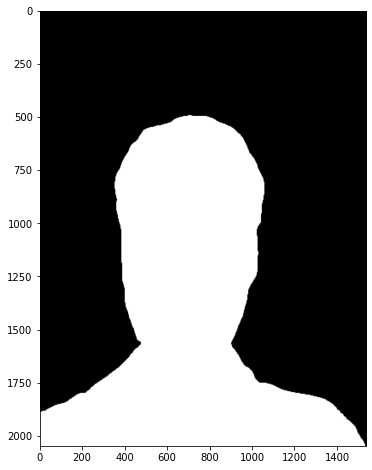

In [15]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함

# 더 큰 피규어 생성
plt.figure(figsize=(10,8))  # 원하는 크기로 조절 가능하다.

seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

(666, 1000)


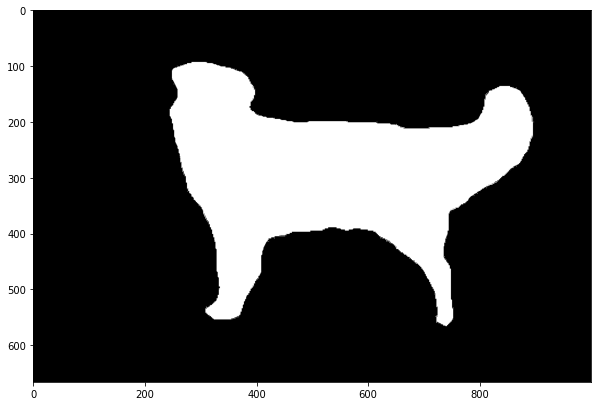

In [25]:
# 두번째 동물사진 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서 변경한다.

seg_color_dog = (128, 0, 64) 

plt.figure(figsize=(10,8))  # 원하는 크기로 조절 가능하다.

seg_map_dog = np.all(output2==seg_color_dog, axis=-1) 
print(seg_map_dog.shape) 
plt.imshow(seg_map_dog, cmap='gray')
plt.show()

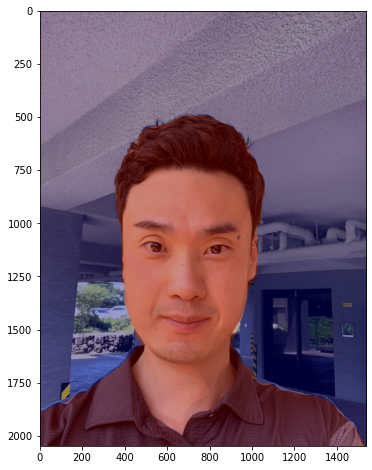

In [26]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show_person = img_orig_person.copy()          # 첫번째 인물사진


# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255


# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)


# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show_person = cv2.addWeighted(img_show_person, 0.6, color_mask, 0.4, 0.0)     # 첫번째 인물사진



# 더 큰 피규어 생성
plt.figure(figsize=(10,8))                                          # 원하는 크기로 조절 가능하다.

plt.imshow(cv2.cvtColor(img_show_person, cv2.COLOR_BGR2RGB))        # 첫번째 인물사진
plt.show()                                           




In [27]:
print(img_show_person.shape)    # img_show의 인물사진 크기와 채널 수 출력
print(color_mask.shape)  # color_mask의 크기와 채널 수 출력

(2048, 1536, 3)
(2048, 1536, 3)


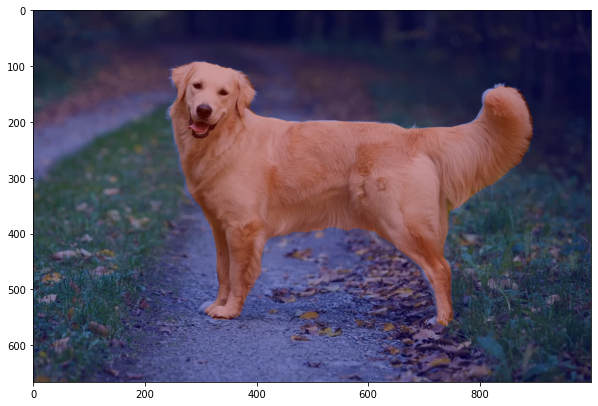

In [28]:
## 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력

img_show_dog = img_orig_dog.copy()        # 두번째 동물사진


# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_dog = seg_map_dog.astype(np.uint8) * 255 


# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask_dog = cv2.applyColorMap(img_mask_dog, cv2.COLORMAP_JET)


# color_mask를 img_show2와 같은 크기로 리사이즈합니다
color_mask_dog = cv2.resize(color_mask_dog, (img_show_dog.shape[1], img_show_dog.shape[0]))


# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show_dog = cv2.addWeighted(img_show_dog, 0.6, color_mask_dog, 0.4, 0.0)     # 두번째 동물사진


# 더 큰 피규어 생성
plt.figure(figsize=(10,8))  # 원하는 크기로 조절 가능하다.

plt.imshow(cv2.cvtColor(img_show_dog, cv2.COLOR_BGR2RGB))               # 두번째 동물사진

plt.show()                                           


In [20]:
print(img_show_dog.shape)   # img_show2의 동물사진 크기와 채널 수 출력
print(color_mask_dog.shape)  # color_mask의 크기와 채널 수 출력

(666, 1000, 3)
(666, 1000, 3)


# 배경 흐리게 하기 (시간부족으로 인물만 해보았습니다)

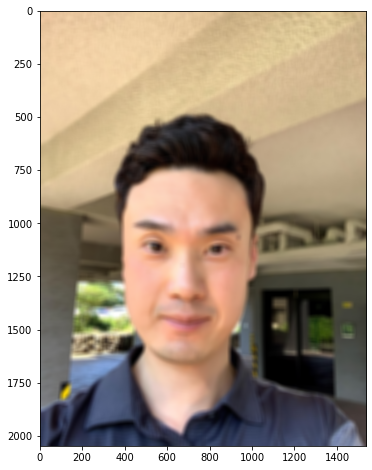

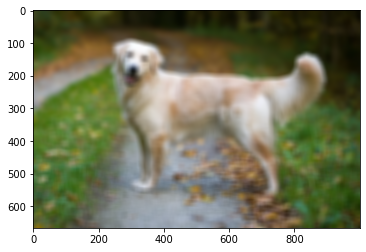

In [42]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요

img_orig_blur = cv2.blur(img_orig_person, (25,25)) # 첫번째 인물사진
img_orig_blur2 = cv2.blur(img_orig_dog, (20,20)) # 첫번째 동물사진



# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   

# 더 큰 피규어 생성
plt.figure(figsize=(10,8))  # 원하는 크기로 조절 가능하다.

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기

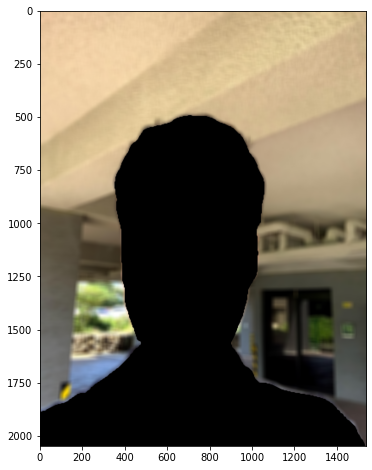

In [43]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)


# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.

img_bg_mask = cv2.bitwise_not(img_mask_color)



# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!

# 더 큰 피규어 생성
plt.figure(figsize=(10,8))  # 원하는 크기로 조절 가능하다.

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)   # 인물사진 출력
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


# 흐린 배경과 원본 영상 합성

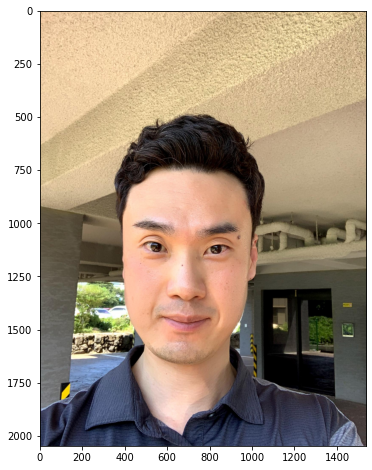

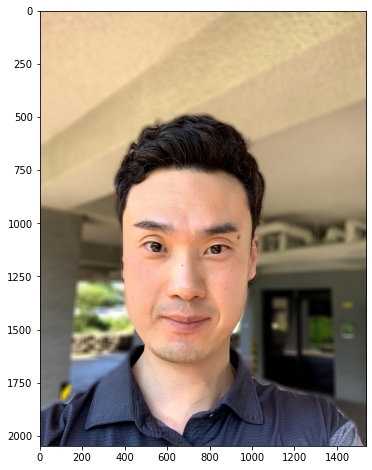

In [52]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.

img_concat = np.where(img_mask_color==255, img_orig_person, img_bg_blur)



# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

# 더 큰 피규어 생성
plt.figure(figsize=(10,8))                                        # 원하는 크기로 조절 가능하다.

plt.imshow(cv2.cvtColor(img_orig_person, cv2.COLOR_BGR2RGB))
plt.show()

# 더 큰 피규어 생성
plt.figure(figsize=(10,8))                                        # 원하는 크기로 조절 가능하다.

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 프로젝트 서머리  
<br>

먼저 이 프로젝트를 통해 세그멘테이션 기법을 적용하여 사진에서 등장 인물과 강아지를 분리하여 blur 처리르 한 후에 다시 합치는
등의 사진합정과정을 진행하였습니다.
이 프로젝트는 이미지 분할을 통해 사람과 동물을 인식하고, 이를 시각적으로 표현하는 작업을 수행했습니다.   
이를 위해 OpenCV와 PixelLib 라이브러리를 사용했습니다.

1. 이미지 로드: 먼저, 원본 이미지를 로드하고, 이 이미지의 크기를 출력했습니다.   
이 과정에서 OpenCV의 imread 함수를 사용했습니다.  

2.이미지 분할: 그런 다음, PixelLib 라이브러리를 사용하여 이미지를 분할했습니다.   
이 라이브러리는 이미지에서 사람과 동물을 분리하는 데 매우 유용합니다.   
이 과정에서는 PixelLib의 segmentAsPascalvoc 함수를 사용했습니다.

3. 분할 결과 출력: 분할된 이미지를 출력한 후, 분할된 부분을 다른 색상으로 표시하기 위해 색상 마스크를 생성했습니다.   
이 마스크는 원본 이미지와 합쳐져서 최종 결과를 생성합니다.  

4. 색상 마스크 생성: 분할된 부분을 다른 색상으로 표시하기 위해 색상 마스크를 생성했습니다.  
이 과정에서는 OpenCV의 applyColorMap 함수를 사용했습니다.

45. 이미지 합성: 마지막으로, 원본 이미지와 색상 마스크를 합쳐서 최종 결과를 생성했습니다.   
이 과정에서는 OpenCV의 addWeighted 함수를 사용했습니다.

이 프로젝트를 통해 이미지 처리에 대한 기본적인 이해를 얻을 수 있었습니다.  
특히, 이미지 분할과 색상 마스크 생성 등의 기법을 배울 수 있었습니다.  
또한, OpenCV와 PixelLib와 같은 라이브러리를 사용하여 이러한 작업을 쉽게 수행할 수 있다는 것을 알게 되었습니다.   
이러한 라이브러리는 이미지 처리 작업을 단순화하고, 복잡한 알고리즘을 쉽게 구현할 수 있게 해줍니다.



# 조필선 프로젝트 회고록  
<br><br>

**어려웠던 점** :프로젝트 진행중에 생각한 대로 이미지 분할이나 처리가 예상한 결과대로 진행이 잘 되지않아서 많은 시간을 소비하였습니다.
같은 조 동료 그루의 조언을 통해서 코드의 처음부터 끝까지 변수명을 확실히 구분할 수 있도록 변수명을 재정의 하고 나서야
에러를 잡고 그 다은 단계로 진행할 수 있었습니다.
그 다음에는 인물 사진을 처리하는데는 문제가 없었으나 강아지 사진을 함수로 처리하는데 이미지 크기와 채널 수는 맞춰야 하는 것과
같은 세부 사항에도 주의를 기울여야 했었습니다.  
이 프로젝트는 이미지 처리에 대한 이론적인 지식을 필요로 합니다.   
예를 들어, 색상 공간 변환, 이미지 분할 등의 개념을 이해해야 합니다. 이러한 지식이 없으면 코드를 이해하고 수정하는 데 어려움을 겪을 수 있습니다.


**배운점** : 혼자서 코드를 작성하고 진행하다보니 내가 알지 못하는 단계에서 많은 부분이 Mise가 되고 놏치고 있다는 것을 알게 되었고,
디버깅을 위해서 부분적인 구역만을 살펴볼 것이 아니라 문제가 난 코드 이전에서부터 천천히 검토하는 방법을 배웠습니다.  
이러한 세부 사항을 놓치면 에러가 발생하므로, 코드를 작성할 때 이러한 점을 유의해야 합니다.

**결론 및 향후 계획**

죄송합니다. 프로젝트를 다 완성하지 못햇습니다. 인물 사진에 크로마키 기법을 이용해서 새로운 배경을 합성하는 사진을 꼭 만들어보고
싶었으나 시간이 부족하여 마무리하지 못했습니다.그렇지만 정말로 재밌었던 거 같았습니다.
이 프로젝트를 통해 얻은 지식과 경험을 바탕으로, 더양한 사진을을 이용해서 내가 원하는 결과물을 도출해 보고 싶습니다.